In [1]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

from src.cache import cache

set_matplotlib_formats("svg")

In [3]:
import json

from src.paths import external_data

# read all json files from folder data/external/nexis/climate/json
# in files like 2020-01-01/*.json

data = []
for file in tqdm(list(external_data.glob("nexis/climate/json/**/*.json"))):
    with open(file) as f:
        item = json.load(f)
        # parse date field
        item["date"] = pd.to_datetime(item["date"])
        data.append(item)

  0%|          | 0/29013 [00:00<?, ?it/s]

In [4]:
from pprint import pprint

df = pd.DataFrame(data)
df["text"] = df["text"].str.removeprefix(")").str.strip()
# group texts and titles for each date together
df["text"] = (
    df["title"]
    + "\n\n"
    + df["location"].fillna("")
    + " "
    + df["text"].fillna("").str[:500]
)
df["date"] = df["date"].dt.date
s = df.groupby("date").agg({"text": "\n\n".join})["text"]
# fill missing dates with empty strings
s = s.reindex(
    pd.date_range(pd.Timestamp("2020-01-01"), pd.Timestamp("2022-12-31")), fill_value=""
)
s = s.shift(1)
# s = (
#     s.shift(2)
#     + "\n\n---\n\n"
#     + s.shift(4)
#     + "\n\n---\n\n"
#     + s.shift(3)
#     + "\n\n---\n\n"
#     + s.shift(2)
#     + "\n\n---\n\n"
#     + s.shift(1)
# )
texts = s

# texts.sample(10)

In [5]:
texts.str.split().str.len().describe()

count     1095.000000
mean     14649.410959
std      10489.251662
min          0.000000
25%       5225.000000
50%      13895.000000
75%      21980.500000
max      62892.000000
Name: text, dtype: float64

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.naive_bayes import ComplementNB

from src.features.time_series import get_lagged_df

df = get_lagged_df(
    "occ_protest", lags=range(-7, 1), ignore_group=True, region_dummies=True
)
X_ts = df.drop(columns=["occ_protest", "occ_protest_lag0"])
X_ts = X_ts[[c for c in X_ts.columns if not c.startswith("weather_")]]
y = df.occ_protest

tscv = TimeSeriesSplit(n_splits=10)
cvs = cross_val_score(ComplementNB(), X_ts, y, cv=tscv, scoring="f1")
print(f"Cross-validated F1 score: {cvs.mean():.3f} +/- {cvs.std():.3f}")

  0%|          | 0/16 [00:00<?, ?it/s]

Cross-validated F1 score: 0.192 +/- 0.046


In [8]:
# import nltk
# nltk.download('stopwords')

In [9]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

# use cross_val_score with text processing pipeline (including german stopwords)

vec = TfidfVectorizer(
    stop_words=stopwords.words("german"),
    ngram_range=(1, 2),
    max_features=1000,
    min_df=5,
    max_df=0.8,
    norm="l2",
    # sublinear_tf=True,
)
text_clf = Pipeline([("tfidf", vec), ("clf", ComplementNB())])

X_text = texts.iloc[7:].repeat(13).reset_index(drop=True)
cvs = cross_val_score(text_clf, X_text, y, cv=tscv, scoring="f1", n_jobs=4, verbose=100)
print(f"Cross-validated F1 score: {cvs.mean():.3f} +/- {cvs.std():.3f}")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.027) total time=  18.1s
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   19.5s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.143) total time=  30.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   31.9s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.096) total time=  46.5s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   48.5s
[CV] START ..

In [10]:
from sklearn.compose import ColumnTransformer

prep = ColumnTransformer(transformers=[("tfidf", vec, "text")], remainder="passthrough")
combi_clf = Pipeline([("prep", prep), ("clf", ComplementNB())])

X = pd.concat([X_ts, X_text], axis=1)
cvs = cross_val_score(combi_clf, X, y, cv=tscv, scoring="f1", n_jobs=4, verbose=10)
print(f"Cross-validated F1 score: {cvs.mean():.3f} +/- {cvs.std():.3f}")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.250) total time=  19.7s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.277) total time=  34.2s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.171) total time=  52.3s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.217) total time= 1.2min
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:  2.0min remaining:  2.0min


[CV] START .....................................................................
[CV] END ................................ score: (test=0.154) total time= 2.2min
[CV] START .....................................................................
[CV] END ................................ score: (test=0.180) total time= 2.6min


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  3.5min remaining:  1.5min


[CV] END ................................ score: (test=0.141) total time= 3.0min
[CV] END ................................ score: (test=0.173) total time= 3.2min
[CV] END ................................ score: (test=0.217) total time= 3.3min
Cross-validated F1 score: 0.204 +/- 0.045


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  6.1min finished


In [11]:
from sklearn.model_selection import KFold, cross_val_predict

cv = KFold(n_splits=2, shuffle=False)
X_text_proba = cross_val_predict(
    text_clf, X_text, y, cv=cv, method="predict_proba", n_jobs=4, verbose=100
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.3min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:  4.2min remaining:  2.8min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  6.8min finished


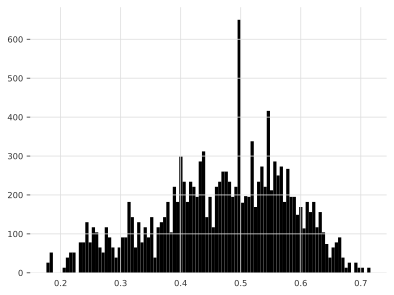

In [12]:
plt.hist(X_text_proba[:, 1], bins=100)
plt.show()

In [13]:
X_text_proba = pd.Series(X_text_proba[:, 1], name="text_proba")

In [14]:
X_augmented = pd.concat([X_ts, X_text_proba], axis=1)
cvs = cross_val_score(ComplementNB(), X_augmented, y, cv=tscv, scoring="f1")
print(f"Cross-validated F1 score: {cvs.mean():.3f} +/- {cvs.std():.3f}")

Cross-validated F1 score: 0.193 +/- 0.046


input lenghts:

- electra: 128 tokens
- bert: 512 tokens
- llama 2: 4096 tokens